In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model, load_model  
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random  
import math 
import os 
import re #Модуль Re для регулярных выражений в Python
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output
from google.colab import drive

import gc

import time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Базы/moscow.csv',sep = ';')

In [ ]:
df = df.iloc[::2,:]
data = df.values

In [ ]:
df[0:10]

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
10,1,Шелепиха м.,15п,9/36 К,NaN,NaN,44/14.7/19.2,12700000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,"1-комн. квартира в ЖК ""Сердце столицы"" на 9 эт..."
12,1,Улица Дмитриевского м.,2п,7/16 П,Л,Р,43/20/8,6500000.0,NaN,NaN,25.07.2019,14.0,Привлекательные,Предлагаю купить Однокомнатную квартиру с удоб...
14,1,Бульвар Рокоссовского м.,2п,2/5 К,Б,С,31/17/6,6000000.0,NaN,NaN,25.07.2019,15.0,Привлекательные,"Теплая, светлая квартира с высоким потолком в ..."
16,1,Марьина Роща м.,10п,7/14 П,2Б,NaN,38.9/20.9/8.5,8900000.0,NaN,NaN,25.07.2019,16.0,Привлекательные,"Продается 1-комн. квартира, площадью 38.9 м2 в..."
18,1,Марьино м.,20п,10/24 М-К,NaN,-,30.9/17.9/10,5999984.0,NaN,NaN,25.07.2019,16.0,Привлекательные,Предлагается уютная квартира в ЖК комфорт клас...


In [ ]:
data

array([['1', 'Шелепиха м.', '12п', ..., 1.0, 'Привлекательные',
        'Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!'],
       ['1', 'Пятницкое шоссе м.

In [ ]:
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


# Feature Engineering

In [ ]:
# d - строка data со всеми значениями
def getRoomsCount(d, maxRoomCount):
  count_room_st = d[0]
  count_room = 0
  try:
    count_room = int(count_room_st)
    if count_room > maxRoomCount:
      count_room = maxRoomCount
  except:
    if count_room_st == count_room_st:
      if 'Ст' in count_room_st:
        count_room = maxRoomCount + 1

  return count_room

  #Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) 
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2)
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] 
  metro = 0
  
  if (metroStr in allMetroNames): 
    metro = allMetroNames.index(metroStr)+1 
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #в OHE
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] 
  
  metroDistance = 0 
  metroDistanceType = 0 
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #создадим вектор длины 3*7 = 21
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance


def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0       #Тип дома
  floor = 0           #Этаж квартиры
  floors = 0          #Этажность дома
  isLastFloor = 0     #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем индекс разделителя "/"
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем индекс разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): 
          floor = 1 

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в OHE
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] 
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в OHE
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] 
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/")
    try:
      area = float(areaStr[:slashIndex])  #Берём число до разделителя и превращаем в число
    except:
      area = 0                            #Если не получается, возвращаем 0
  else:
    area = 0                              #Или если нет разделителя, возвращаем 0
    
  return area

#Полуаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

**Создание тренировочного датасета**

In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип наполнения листа истинными значениями
data1 = data[oneRoomMask]                               #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:

xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


# Preprocessing

## Scaling numerical data

In [ ]:

#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

In [ ]:
xTrainScaled.shape[0]

62504

In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

## Text to BOW

In [ ]:
data[0]

array(['1', 'Шелепиха м.', '12п', '35/37 М', nan, '2', '64.1/23/20',
       19500000.0, nan, nan, '25.07.2019', 1.0, 'Привлекательные',
       'Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно 

In [ ]:
data2 = data1[:,-1].reshape(62504) 

In [ ]:
data2[688]

'Лот:57800 БЕСТ-Недвижимость на Баррикадной, Агент Диана +7-(926)-602-0640 Уютная квартира! В одном из самых инфраструктурно развитых и экологически благополучных районов города! Косметический ремонт, полностью новая электропроводка, новые трубы водоснабжения, встроенная кухня, бытовая техника. Из окна открывается великолепный панорамный вид на город, на Удальцовские пруды. Парк им 50-летия Октября 8 минут пешком, 15 минут пешком - Воронцовский парк; в шаговой доступности 3 детских сада, стоматологическая поликлиника, школы, гимназии, магазины, рестораны, кинотеатр, отделения банков. До м Проспект Вернадского 5 мин пешком! 12 мин пешком до строящейся станции метро Улица Новаторов, МФЦ района 3 мин пешком. Дом экспериментальный, крупнопанельный, серии М-10, 1969 г.п. Въезд во двор через шлагбаум, нет проблем с парковкой. Детская площадка во дворе. 1 взрослый собственник. Собственность 2004 года. Свободная продажа!'

In [ ]:
#print(data2[0], end='\n') 
data3 = []
for i in data2:
  try:
    new = re.sub('\d','',i)
    data3.append(new)
  except:     #688 и ещё какие-то не фильтруются и получается ошибка СЕРЬЁЗНЫЙ И НЕПОНЯТНЫЙ БАГ
#    new1 = re.sub('\d','',i)
    data3.append(new)
len(data3)

62504

In [ ]:
max_count_words = 1500
tokenizer = Tokenizer(max_count_words,filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff\[0-9]',oov_token= 'unknown', lower=True)

tokenizer.fit_on_texts(data3)
items = list(tokenizer.word_index.items())

In [ ]:
print(items[:10])
print(len(items))

[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('от', 6), ('м', 7), ('квартира', 8), ('кв', 9), ('для', 10)]
40868


In [ ]:
secuence_tr = tokenizer.texts_to_sequences(data3) # Обучающие тесты в индексы
#secuence_te = tokenizer.texts_to_sequences(x_test)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", data3[1])
print("Он же в виде последовательности индексов: ", secuence_tr[1], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Зеленоград к. однокомнатная квартира общ..//  ( Общая с учетом лоджии  кв.м.) Дом расположен рядом со станцией Крюково.  эт.  эт. дома.  Большая лоджия.  Сан. узел раздельный. Свободная продажа. ПОКАЗ В ЛЮБОЕ ВРЕМЯ КЛЮЧИ НА РУКАХ.
Он же в виде последовательности индексов:  [1, 36, 81, 8, 885, 94, 5, 549, 566, 9, 7, 27, 39, 20, 91, 1, 1, 1, 1, 14, 203, 137, 1092, 1064, 385, 68, 50, 222, 2, 819, 198, 411, 4, 1469] 



In [ ]:
len(secuence_tr)

62504

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(secuence_tr) #П одаем xTrain в виде списка


In [ ]:
print(xTrain.shape)
print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(yTrain.shape)


(62504, 109)
(62504, 1500)
(62504,)


# Modelling


In [ ]:
xTrainScaled.shape

(62504, 109)

In [ ]:
xTrainScaled.shape[0]

62504

## Callback

In [ ]:
plot_tr_mae = []
plot_tr_mae1 = []
loss_gist = []
t_sum = []

def on_epoch_end(epoch, logs):
  t1 = time.time()
  
  pred = model.predict([xTrainScaled[valMask], xTrain01[valMask]])              #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten()                      #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled                                         #Считаем разность предсказания и правильных цен
  absDelta = abs(delta)                                                         #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки на проверочной", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

  pred1 = model.predict([xTrainScaled[~valMask], xTrain01[~valMask]]) #Полуаем выход сети на обучающей выборке
  predUnscaled1 = yScaler.inverse_transform(pred1).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled1 = yScaler.inverse_transform(yTrainScaled[~valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta1 = predUnscaled1 - yTrainUnscaled1 #Считаем разность предсказания и правильных цен
  absDelta1 = abs(delta1) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки на обучающей", round(sum(absDelta1) / (1e+6 * len(absDelta1)),3)) #Выводим усреднённую ошибку в миллионах рублей

#............................................mae......................................................

  mae_i = round(sum(absDelta) / (1e+6 * len(absDelta)),3)
  plot_tr_mae.append(mae_i)
  plt.plot(plot_tr_mae,label = 'проверочная')
  plt.xlabel('Эпоха')
  plt.ylabel('Mae [млн]')
  plt.title('График Mae')

  mae_i1 = round(sum(absDelta1) / (1e+6 * len(absDelta1)),3)
  plot_tr_mae1.append(mae_i1)
  plt.plot(plot_tr_mae1,label = 'обучающая')

  plt.legend()
  plt.show()

#.............................................scatter.....................................................

  plt.scatter(yTrainUnscaled, predUnscaled)
  plt.xlabel('Правильные значение')
  plt.ylabel('Предсказания')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([min(yTrain), max(yTrain)], [min(yTrain), max(yTrain)])
  plt.show()

#............................................гистограмма ошибок......................................................

  loss = np.mean(abs((predUnscaled-yTrainUnscaled)/yTrainUnscaled))
  loss_gist.append(loss)
  plt.bar(range(0,epoch+1),loss_gist)
  plt.title('Гистограмма ошибки')
  plt.show()

#.............................................время обучения.....................................................

  n = gc.collect()
  print("Number of unreachable objects collected by GC:", n)

  t2 = time.time() - t1
  t_sum.append(t2)
  t_mass = np.array(t_sum)
  t_summarnoe = t_mass.sum()
  speed = t_mass.mean()
  t_yet = speed * (10 - (epoch+1)) #10 - количество эпох

  print('Время обучения на эпохе -',round(t2,1),' время обучения суммарное -',round(t_summarnoe,1), ' времени остаётся до конца обучения -',round(t_yet,1))

#...................................сохранение модели с лучшей точностью...................................................
  if epoch > 1:
    if loss_gist[epoch] < loss_gist[epoch-1]:
      model.save('/content/sample_data/m_best.h5')




# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
print(type(yTrain))

<class 'numpy.ndarray'>


## Training

Epoch 1/10
391/391 [==============================] - 2s 4ms/step - loss: 1.8628 - val_loss: 0.0732
Эпоха 0 модуль ошибки на проверочной 2.667
Эпоха 0 модуль ошибки на обучающей 2.939


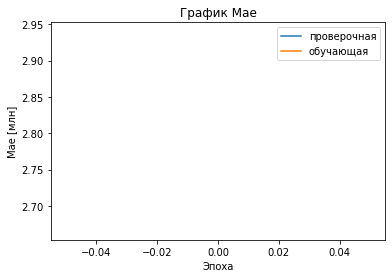

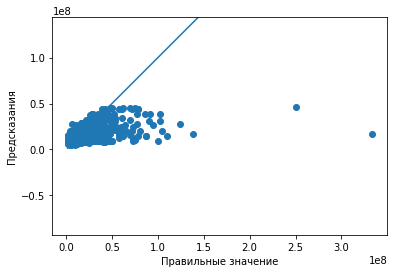

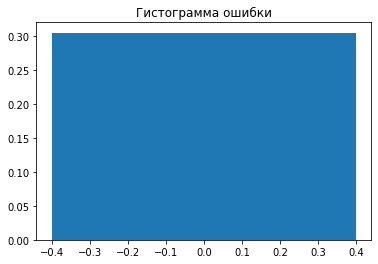

Number of unreachable objects collected by GC: 13888
Время обучения на эпохе - 2.7  время обучения суммарное - 2.7  времени остаётся до конца обучения - 24.5
Epoch 2/10
391/391 [==============================] - 1s 3ms/step - loss: 2.5821 - val_loss: 0.0601
Эпоха 1 модуль ошибки на проверочной 2.39
Эпоха 1 модуль ошибки на обучающей 2.564


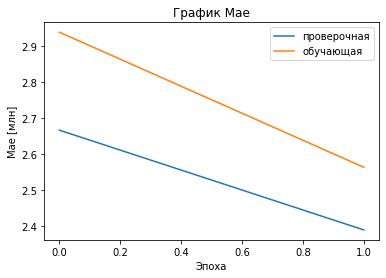

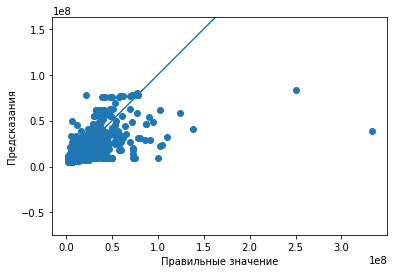

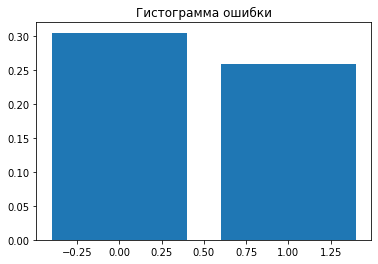

Number of unreachable objects collected by GC: 7800
Время обучения на эпохе - 2.8  время обучения суммарное - 5.5  времени остаётся до конца обучения - 22.2
Epoch 3/10
391/391 [==============================] - 1s 3ms/step - loss: 1.5444 - val_loss: 0.0573
Эпоха 2 модуль ошибки на проверочной 2.608
Эпоха 2 модуль ошибки на обучающей 2.743


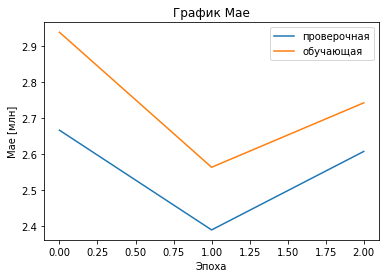

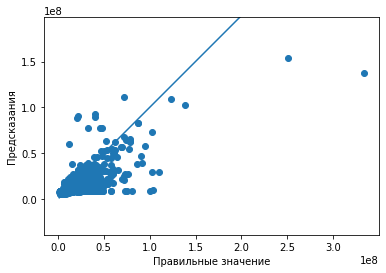

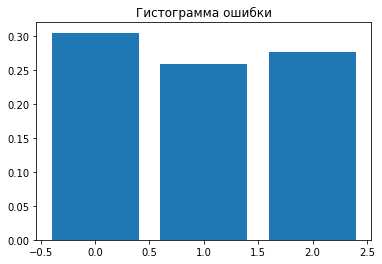

Number of unreachable objects collected by GC: 8069
Время обучения на эпохе - 2.8  время обучения суммарное - 8.4  времени остаётся до конца обучения - 19.5
Epoch 4/10
391/391 [==============================] - 1s 3ms/step - loss: 0.1776 - val_loss: 0.0790
Эпоха 3 модуль ошибки на проверочной 2.464
Эпоха 3 модуль ошибки на обучающей 2.504


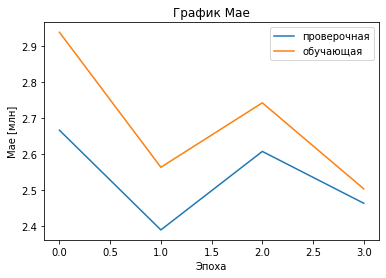

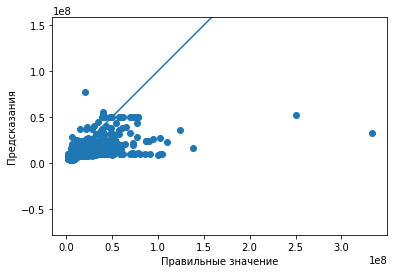

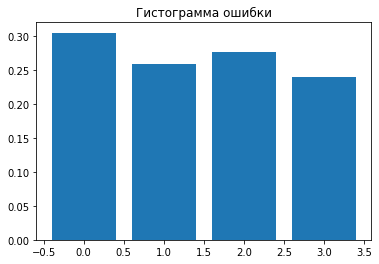

Number of unreachable objects collected by GC: 8160
Время обучения на эпохе - 2.9  время обучения суммарное - 11.2  времени остаётся до конца обучения - 16.8
Epoch 5/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0926 - val_loss: 0.0562
Эпоха 4 модуль ошибки на проверочной 2.211
Эпоха 4 модуль ошибки на обучающей 2.158


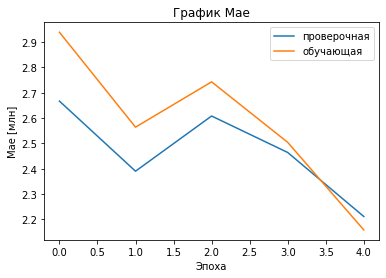

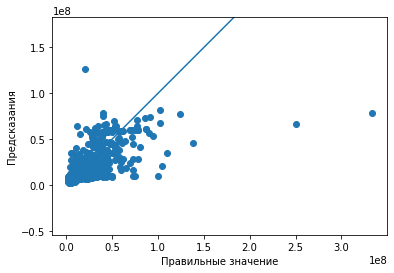

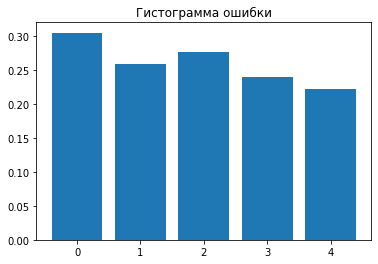

Number of unreachable objects collected by GC: 8091
Время обучения на эпохе - 2.8  время обучения суммарное - 14.0  времени остаётся до конца обучения - 14.0
Epoch 6/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0524 - val_loss: 0.0565
Эпоха 5 модуль ошибки на проверочной 1.998
Эпоха 5 модуль ошибки на обучающей 2.026


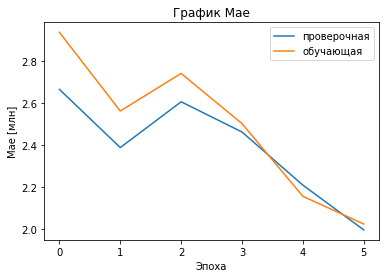

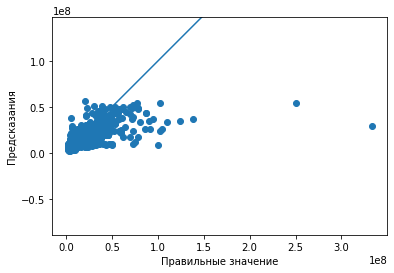

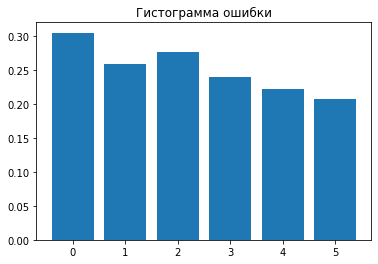

Number of unreachable objects collected by GC: 7848
Время обучения на эпохе - 2.8  время обучения суммарное - 16.9  времени остаётся до конца обучения - 11.2
Epoch 7/10
391/391 [==============================] - 1s 3ms/step - loss: 0.1729 - val_loss: 0.0486
Эпоха 6 модуль ошибки на проверочной 1.871
Эпоха 6 модуль ошибки на обучающей 1.759


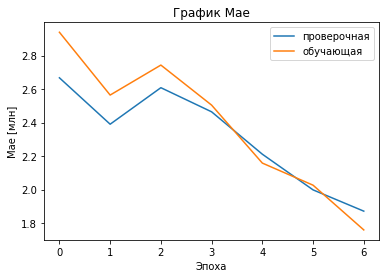

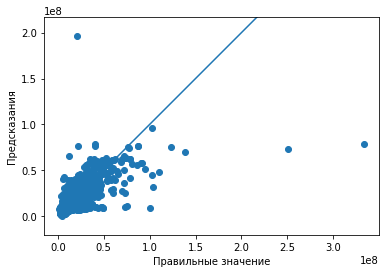

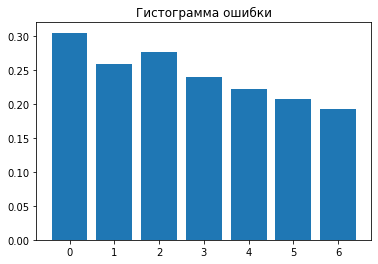

Number of unreachable objects collected by GC: 8233
Время обучения на эпохе - 2.9  время обучения суммарное - 19.7  времени остаётся до конца обучения - 8.5
Epoch 8/10
391/391 [==============================] - 1s 4ms/step - loss: 0.0769 - val_loss: 0.0452
Эпоха 7 модуль ошибки на проверочной 1.826
Эпоха 7 модуль ошибки на обучающей 1.693


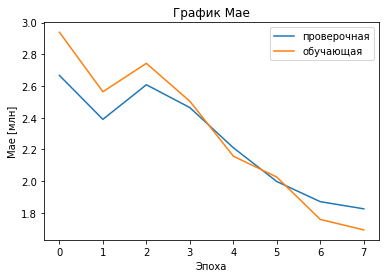

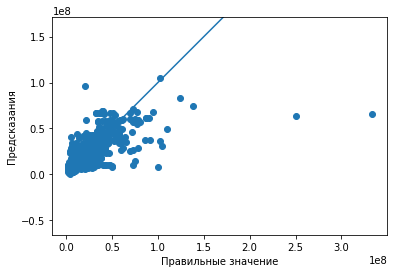

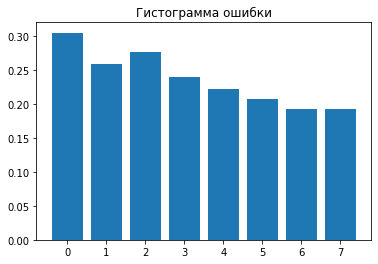

Number of unreachable objects collected by GC: 8325
Время обучения на эпохе - 2.8  время обучения суммарное - 22.5  времени остаётся до конца обучения - 5.6
Epoch 9/10
391/391 [==============================] - 1s 4ms/step - loss: 0.1443 - val_loss: 0.0434
Эпоха 8 модуль ошибки на проверочной 1.777
Эпоха 8 модуль ошибки на обучающей 1.692


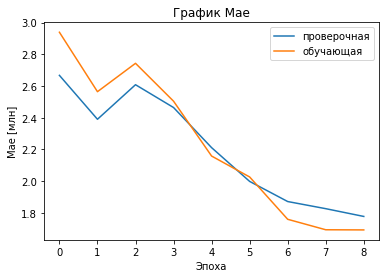

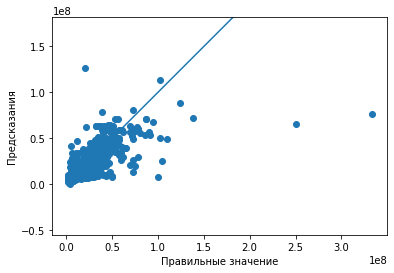

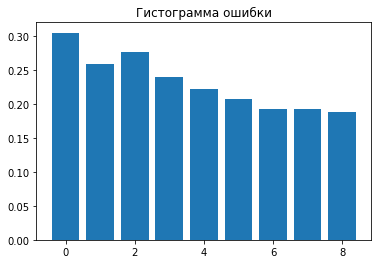

Number of unreachable objects collected by GC: 8327
Время обучения на эпохе - 2.7  время обучения суммарное - 25.2  времени остаётся до конца обучения - 2.8
Epoch 10/10
391/391 [==============================] - 1s 3ms/step - loss: 0.0694 - val_loss: 0.0466
Эпоха 9 модуль ошибки на проверочной 1.747
Эпоха 9 модуль ошибки на обучающей 1.592


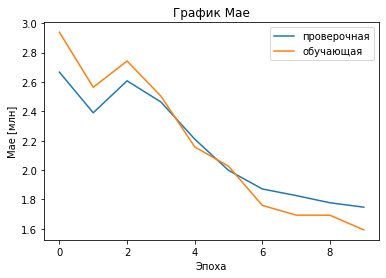

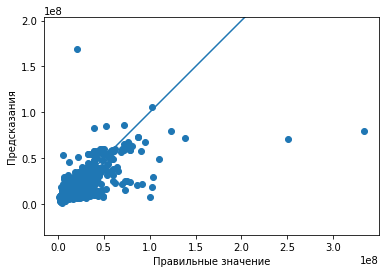

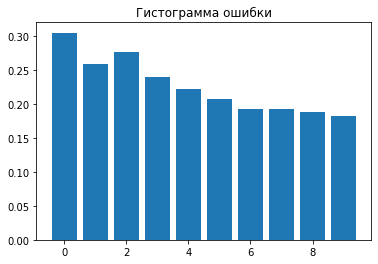

Number of unreachable objects collected by GC: 8271
Время обучения на эпохе - 2.8  время обучения суммарное - 28.1  времени остаётся до конца обучения - 0.0


In [ ]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrain01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x3 = Dropout(0.1)(x1)

x2 = Dense(300, activation="relu")(input2)
x4 = Dropout(0.25)(x2)

x = concatenate([x3, x4])

x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrain01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=10, 
                    validation_data=([xTrainScaled[valMask], xTrain01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=1,
                    callbacks=[pltMae],batch_size = 128)



## Examination

In [ ]:
model5 = load_model('/content/sample_data/m_best.h5')

In [ ]:
pred = model5.predict([xTrainScaled[valMask], xTrain01[valMask]])              #Полуаем выход сети на проверочно выборке
predUnscaled = yScaler.inverse_transform(pred).flatten()                      #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()   #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled                                         #Считаем разность предсказания и правильных цен
absDelta = abs(delta)                                                         #Берём модуль отклонения
print( "модуль ошибки на проверочной", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

модуль ошибки на проверочной 1.747
